In [1]:
import file_tools as flt
import postprocess_tools as ppt
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from ecmwfapi import ECMWFDataServer

Write ERA5 wave parameters to *.tpar boundary condition files

In [2]:
# import data
wavepath = "P:\\1230882-emodnet_hrsm\\vanCas\\Ensemble_Forecast\\boundary_conditions\\waves\\"
wavefield = xr.open_dataset(wavepath + "era5wavefield.nc", engine='netcdf4')

tparpath = "P:\\1230882-emodnet_hrsm\\vanCas\\Ensemble_Forecast\\boundary_conditions\\waves\\boundary_condition_at_points\\"
tparname = "stormxaver_boundary_wavedata"

flt.ecmwfdata.tpar_from_era5_wavefield(wavefield, tparpath, tparname)

Retrieve wind input data from ECMWF data server

In [2]:
dates = ['2013-12-03', '2013-12-04', '2013-12-05', '2013-12-06', '2013-12-07']
members = [i for i in range(1, 51)] # download all ensemble members
hours = [(len(dates) - i + 1) * 24 for i in range(len(dates))] # all forecasts end on December 9th 00:00:00

# Define geographical domain
min_longitude = -12.
max_longitude = 9.
min_latitude = 48.
max_latitude = 64.

# Download data

flt.ecmwfdata.retrieve_tigge_wind_data(dates, members, hours, min_longitude, max_longitude, min_latitude, max_latitude)

# Convert to netcdf compatible with SWAN
grib_path = "P:\\1230882-emodnet_hrsm\\vanCas\\Scripts\\"
ensemble_member_path = "P:\\1230882-emodnet_hrsm\\vanCas\\Ensemble_Forecast\\boundary_conditions\\meteo\\"

flt.ecmwfdata.extract_wind_ensemble_from_tigge(grib_path, "ecmwf_sfc_2013-12-03_00.grb", ensemble_member_path + "forecast_2013-12-03\\", "stormxaver_wind_1203")
flt.ecmwfdata.extract_wind_ensemble_from_tigge(grib_path, "ecmwf_sfc_2013-12-04_00.grb", ensemble_member_path + "forecast_2013-12-04\\", "stormxaver_wind_1204")
flt.ecmwfdata.extract_wind_ensemble_from_tigge(grib_path, "ecmwf_sfc_2013-12-05_00.grb", ensemble_member_path + "forecast_2013-12-05\\", "stormxaver_wind_1205")
flt.ecmwfdata.extract_wind_ensemble_from_tigge(grib_path, "ecmwf_sfc_2013-12-06_00.grb", ensemble_member_path + "forecast_2013-12-06\\", "stormxaver_wind_1206")
flt.ecmwfdata.extract_wind_ensemble_from_tigge(grib_path, "ecmwf_sfc_2013-12-07_00.grb", ensemble_member_path + "forecast_2013-12-07\\", "stormxaver_wind_1207")




Opening Data...


Constructing coordinate arrays...


Constructing data variables...


Opening Data...


Constructing coordinate arrays...


Constructing data variables...


Opening Data...


Constructing coordinate arrays...


Constructing data variables...


Opening Data...


Constructing coordinate arrays...


Constructing data variables...


Opening Data...


Constructing coordinate arrays...


Constructing data variables...




Test wind ensemble mean and spread

In [3]:
member_path = "P:\\1230882-emodnet_hrsm\\vanCas\\Ensemble_Forecast\\boundary_conditions\\meteo\\forecast_2013-12-03\\"
name = 'stormxaver_wind_1203'
ensemble_mean, ensemble_mean_of_square = ppt.estimate.ensemble_mean_dataset(member_path, name, 50, output_vars=['eastward_wind', 'northward_wind'], squared=True)
variance = ppt.estimate.variance_estimator(ensemble_mean, ensemble_mean_of_square)

absolute_speed_of_mean = np.sqrt(np.power(ensemble_mean['eastward_wind'].values, 2) + np.power(ensemble_mean['northward_wind'].values, 2))

normalized_eastwind = ensemble_mean['eastward_wind'].values / absolute_speed_of_mean
normalized_northwind = ensemble_mean['northward_wind'].values / absolute_speed_of_mean



Plot results

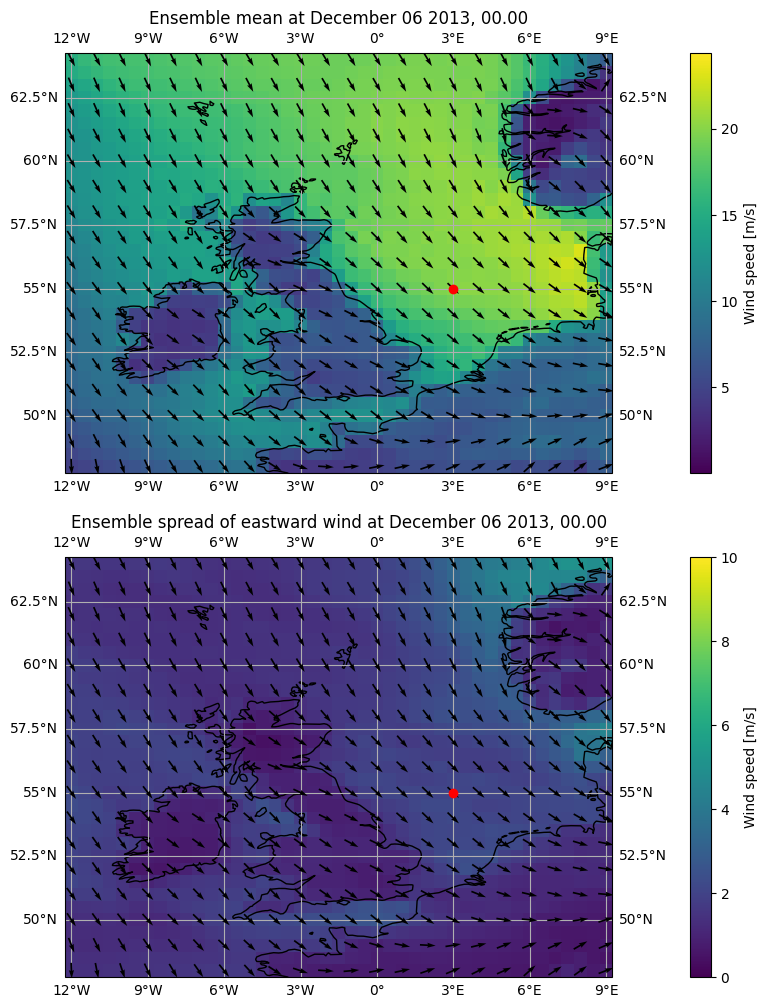

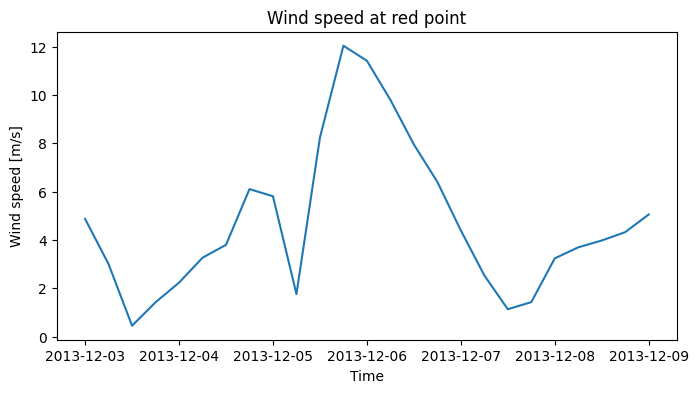

In [6]:
global_mean_max = np.amax(absolute_speed_of_mean)
global_mean_min = np.amin(absolute_speed_of_mean)
global_var_max = np.amax(variance['eastward_wind'].values)

time_index = 12
current_iso = ppt.string.datetime_to_isostring(ensemble_mean['time'].values[time_index])
current_date = ppt.string.isostring_to_datestring(current_iso, year=True)

# test_member = xr.open_dataset(member_path + name + '27.nc', engine='netcdf4')

# absolute_member_speed = np.sqrt(np.power(test_member['eastward_wind'].values, 2) + np.power(test_member['northward_wind'].values, 2))

fig, ax = plt.subplots(2, figsize = (10, 12), subplot_kw={'projection': ccrs.PlateCarree()})

ax[0].coastlines()
ax[1].coastlines()
ax[0].gridlines(draw_labels=True)
ax[1].gridlines(draw_labels=True)

ppt.plot_colormap(fig, ax[0], ensemble_mean['x'], ensemble_mean['y'], absolute_speed_of_mean[time_index, :, :], title=f'Ensemble mean at {current_date}', quantitystr='Wind speed [m/s]',
                  vmin=global_mean_min, vmax=global_mean_max, cmap='viridis')
ppt.plot_colormap(fig, ax[1], ensemble_mean['x'], ensemble_mean['y'], np.sqrt(variance['eastward_wind'].values[time_index, :, :]), title=f'Ensemble spread of eastward wind at {current_date}', quantitystr='Wind speed [m/s]',
                  vmin=0., vmax=10., cmap='viridis')

lon_grid, lat_grid = np.meshgrid(ensemble_mean['x'].values, ensemble_mean['y'].values)
ax[0].quiver(lon_grid[::2,::2], lat_grid[::2,::2], normalized_eastwind[time_index, ::2,::2], normalized_northwind[time_index, ::2,::2], pivot='middle', zorder=3)
ax[1].quiver(lon_grid[::2,::2], lat_grid[::2,::2], normalized_eastwind[time_index, ::2,::2], normalized_northwind[time_index, ::2,::2], pivot='middle', zorder=3)

lon_index = np.argmin(np.absolute(ensemble_mean['x'].values - np.full(ensemble_mean['x'].values.shape, 3)))
lat_index = np.argmin(np.absolute(ensemble_mean['y'].values - np.full(ensemble_mean['y'].values.shape, 55)))

ppt.plot_point_on_colormap(ax[0], 3, 55, color='red')
ppt.plot_point_on_colormap(ax[1], 3, 55, color='red')
plt.show()

figt, axt = plt.subplots(figsize=(8,4))
ppt.plot_timeseries(axt, ensemble_mean['x'], ensemble_mean['y'], 3, 55, absolute_speed_of_mean, ensemble_mean['time'].values,title='Wind speed at red point', quantitystr='Wind speed [m/s]', label='Ensemble mean')

plt.show()


Write a SWAN input file based on one ensemble member

In [2]:
swaninput = flt.Swanstring('member0_testcase', 'SWAN-EPS', '002', '20131204.000000', '20131209.000000', 1)
swaninput.input(420, 480, 'geometry/swan-ns-j22_6-v1a_adjust.bot', windfile='boundary_conditions/meteo/forecast_2013-12-04/stormxaver_wind_12040.nc')
era5wavefield = xr.open_dataset("P:\\1230882-emodnet_hrsm\\vanCas\\Ensemble_Forecast\\boundary_conditions\\waves\\era5wavefield.nc", engine='netcdf4')
# the code needs this xArray dataset to tell SWAN where the boundary conditions are located geographically
swaninput.boundary_condition_tpar(era5wavefield, 'stormxaver_boundary_wavedata', 'P:\\1230882-emodnet_hrsm\\vanCas\\Ensemble_Forecast\\boundary_conditions\\waves\\boundary_condition_at_points\\',
                              'boundary_conditions/waves/boundary_condition_at_points/', 420, 480)
swaninput.physics(generation=3)
swaninput.numerical_parameters(maxitns=20)
swaninput.output('geometry/output_locations/', '', 'stormxaver1204')
swaninput.write_to_file("P:\\1230882-emodnet_hrsm\\vanCas\\Ensemble_Forecast\\Tests\\")

Write SWAN input files for a full EPS run

In [4]:
path = "P:\\1230882-emodnet_hrsm\\vanCas\\Ensemble_Forecast\\EPSruns\\full\\input\\"
fname = "full"
flt.write_EPS_input.standard_swn(path, fname, ensemble_size=50)
flt.write_EPS_input.standard_sh(path, fname, ensemble_size=50)

Write SWAN input files for a multilevel EPS run

In [3]:
path = "P:\\1230882-emodnet_hrsm\\vanCas\\Ensemble_Forecast\\EPSruns\\spatial_resolution3\\input\\"
fname = "spatial_resolution3"
N_list = [30, 15, 5]
flt.write_EPS_input.ML_swn(path, fname, N_list)
flt.write_EPS_input.ML_sh(path, fname, N_list)

Write SWAN input files for a multilevel multifidelity EPS run

In [2]:
path = "P:\\1230882-emodnet_hrsm\\vanCas\\Ensemble_Forecast\\EPSruns\\lspace_ffreqitns_15_8_2_22_33_40\\input\\"
fname = "lspace_ffreqitns"
N_list = [15, 8, 2]
r_list = [22, 33, 40]
flt.write_EPS_input.MLMF_swn(path, fname, N_list, r_list)
flt.write_EPS_input.MLMF_sh(path, fname, N_list, r_list)

Write SWAN input files for a nested multilevel EPS run

In [2]:
path = "P:\\1230882-emodnet_hrsm\\vanCas\\Ensemble_Forecast\\EPSruns\\ospace_ifreqitns_23_10_3_7_5_2\\input\\"
fname = "ospace_ifreqitns"
M_array = np.array([[23, 7],
                    [10, 5],
                    [3, 2]])
flt.write_EPS_input.NML_swn(path, fname, M_array)
flt.write_EPS_input.NML_sh(path, fname, M_array)